# Practical Lab 2: Multivariate Linear Regression, Non-Parametric Models and Cross-Validation

## Done by ***Eris Leksi***

Welcome to Practical Lab 2: Multivariate Linear Regression, Non-Parametric Models and Cross-Validation!

In this lab, we will explore predictive modeling techniques to estimate diabetes disease progression. Our goal is to identify patients at higher risk using models that leverage various features from the Scikit-Learn Diabetes dataset. This notebook follows a clear, structured, and interpretable approach to build and evaluate multiple models.

LET'S START!

## Framing the Problem

**Objective:** Predict the diabetes disease progression a year after baseline using patient baseline data.

This is a regression problem with a continuous target variable. It will serve as a screening tool for physicians to detect risk early.

### 0. Importing all the necessary libraries

In [58]:
import pandas as pd   
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

## Part 1

### 1. Loading the dataset into the dataframe and showing some insights about it

In [3]:
data = load_diabetes(as_frame=True)
X = data.data
y = data.target

df = X.copy() # here we combine the data for the Exploratory Data Analysis (EDA)
df["target"] = y

###  2. Exploratory Data Analysis (EDA)

In [4]:
print(df.head())
print("--------------------------------*--------------------------------*--------------------------------*--------------------------------*")
print(df.columns)
print("--------------------------------*--------------------------------*--------------------------------*--------------------------------*")
print(df.shape)
print("--------------------------------*--------------------------------*--------------------------------*--------------------------------*")
print(df.describe())
print("--------------------------------*--------------------------------*--------------------------------*--------------------------------*")
print(df.info())    

        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0  
--------------------------------*--------------------------------*--------------------------------*--------------------------------*
Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'target'],
      dtype='object')
--------------------------------*---------------------

2.1. Histograms

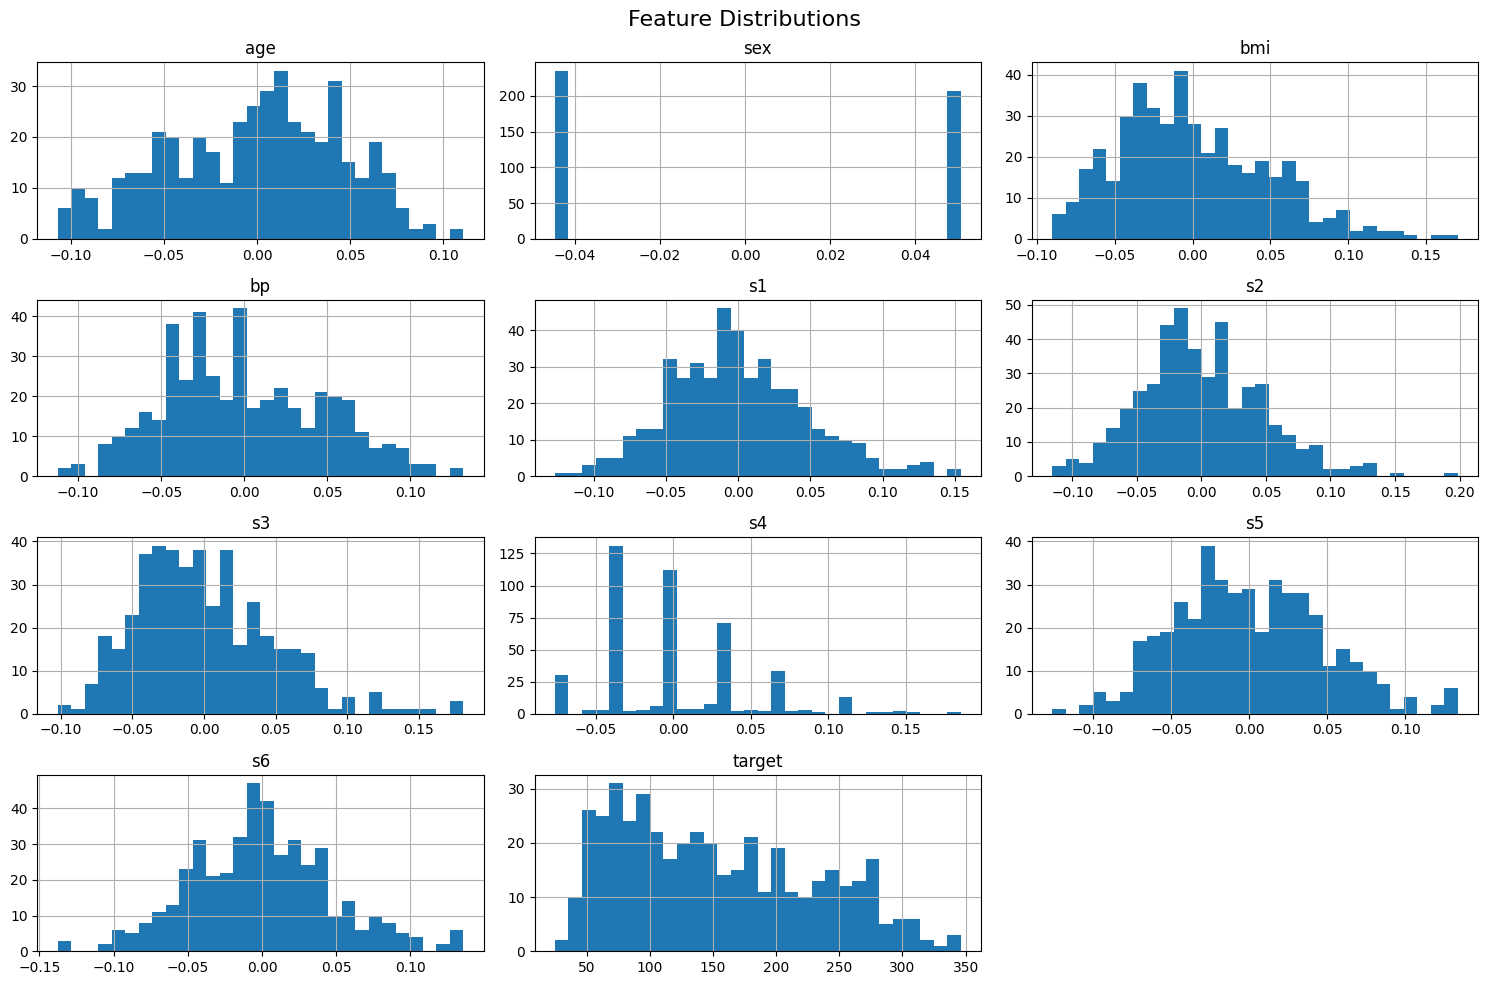

In [14]:
df.hist(bins=30, figsize=(15, 10))
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

### 2.2. Scatter Plots

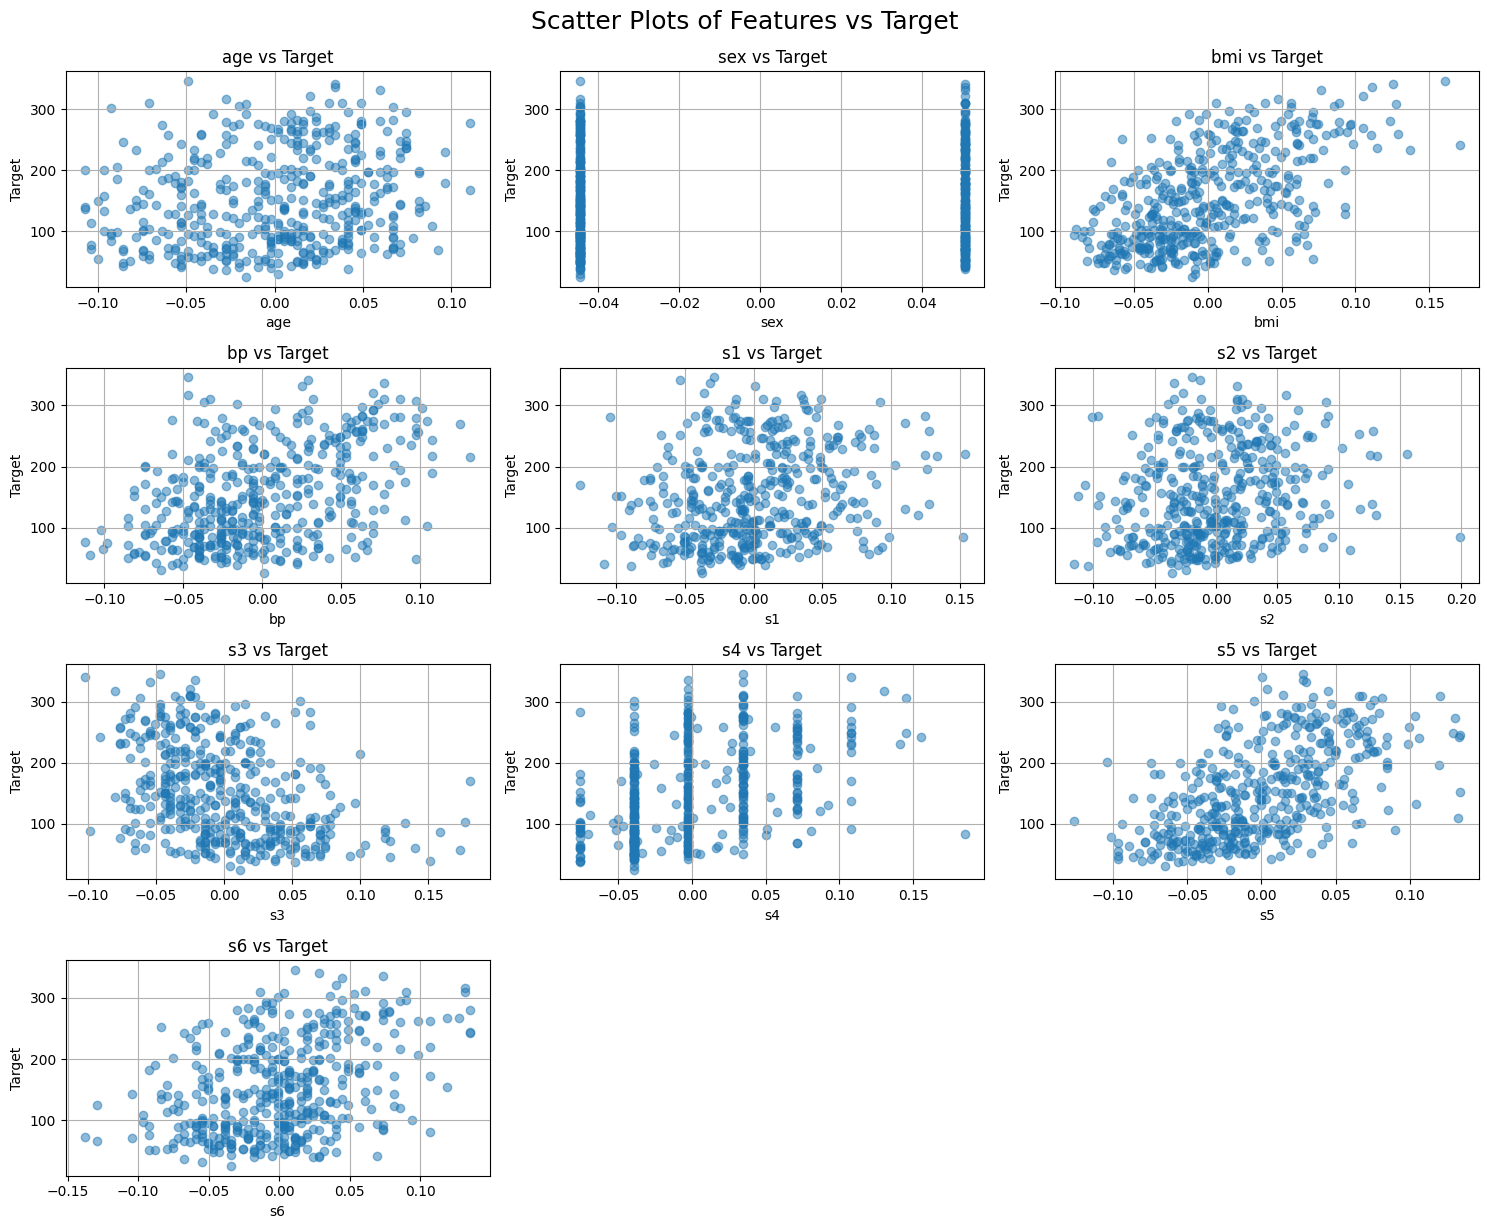

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(X.columns):
    if idx < len(axes):
        axes[idx].scatter(df[col], df['target'], alpha=0.5)
        axes[idx].set_title(f'{col} vs Target')
        if idx >= len(X.columns)-1:  
            for ax in axes[len(X.columns):]:  
                ax.remove()
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Target')
        axes[idx].grid(True)

plt.tight_layout()
plt.suptitle('Scatter Plots of Features vs Target', fontsize=18, y=1.02)
plt.show()

### 2.3. Correlation MATRIX

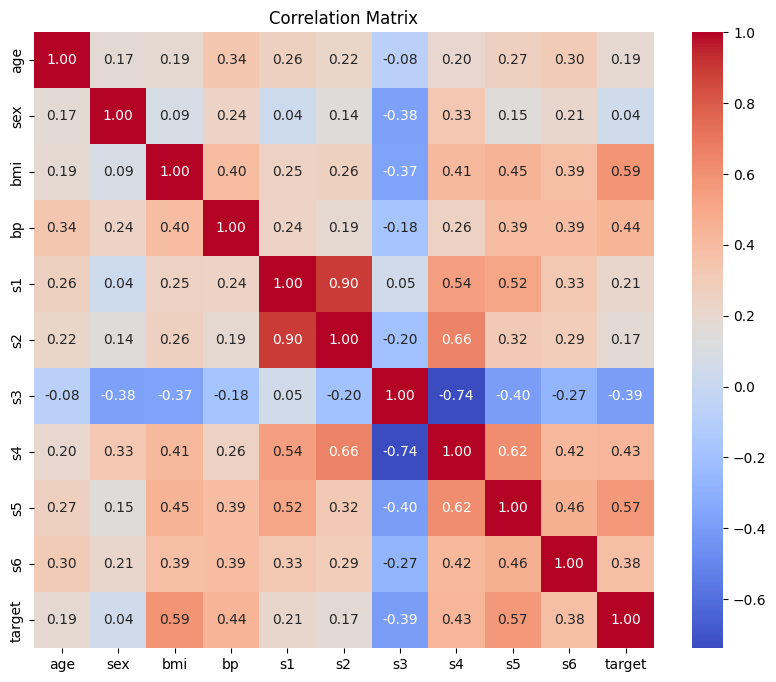

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### 2.4.  Some insights I observed from the plots

- BMI has the strongest positive correlation with the target, indicating its importance.
- Some features (e.g. s2) are negatively correlated.
- Data is already standardized and complete.

### 3. Clean the data

### 3.1. Checking for the missing values

In [19]:
missing_values = df.isnull().sum()
print("Missing values:\n",missing_values)

Missing values:
 age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64


### 3.2. Checking for duplicates and dropping them

In [25]:
print("Before removing duplicates:", df.shape[0])
df = df.drop_duplicates()
print("After removing duplicates:", df.shape[0])

Before removing duplicates: 442
After removing duplicates: 442


### 3.3. Summary about the Cleaning Process

In the previous code cells we looked for missing values and duplicates in the dataset. None of these techniques made a difference to the dataset. This happened because the dataset is very clean. 

This happened because the dataset is a predefined one and is part of the Scikit-Learn library. The diabetes dataset is a preprocessed and standardized dataset, designed for educational and modeling purposes. 

All features are numerical, already scaled, and within reasonable ranges. No duplicates were found after running df.drop_duplicates(), and no inconsistent or anomalous values were detected during EDA. These factors confirm the dataset is clean and ready for modeling with minimal preprocessing required.

### 4. Splitting the dataset into train, validation and test

In [30]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.10 / 0.85, random_state=42)

print(f"Train shape: {X_train.shape}\nValidation shape: {X_val.shape}\nTest shape: {X_test.shape}")

Train shape: (330, 10)
Validation shape: (45, 10)
Test shape: (67, 10)


Now the dataset is splitted into 3 sets and each of them has the respective percentage:

Train Set: 75%

Test Set: 15%

Validation Set: 10% 


## Part 2

### 1. Training models of degree 0-5

In [34]:
bmi_train = X_train[['bmi']]
bmi_val = X_val[['bmi']]
bmi_test = X_test[['bmi']]

results = []
models = []

for degree in range(6):
    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(bmi_train)
    X_poly_val = poly.transform(bmi_val)

    model = LinearRegression().fit(X_poly_train, y_train)
    models.append((model, poly))

    y_pred_train = model.predict(X_poly_train)
    y_pred_val = model.predict(X_poly_val)

    results.append({
        "Degree": degree,
        "Train R2": r2_score(y_train, y_pred_train),
        "Train MAE": mean_absolute_error(y_train, y_pred_train),
        "Train MAPE": mean_absolute_percentage_error(y_train, y_pred_train),
        "Validation R2": r2_score(y_val, y_pred_val),
        "Validation MAE": mean_absolute_error(y_val, y_pred_val),
        "Validation MAPE": mean_absolute_percentage_error(y_val, y_pred_val),
    })

### 2. Comparing the models using the measurements we got from test and validation sets

In [36]:
results_df = pd.DataFrame(results)
print(results_df)

   Degree  Train R2  Train MAE  Train MAPE  Validation R2  Validation MAE  \
0       0  0.000000  66.548209    0.633521      -0.000011       63.447475   
1       1  0.354240  52.278064    0.484624       0.449292       41.997581   
2       2  0.354771  52.267273    0.484479       0.449158       41.757683   
3       3  0.355002  52.223375    0.483564       0.447291       41.741042   
4       4  0.357983  51.944372    0.479635       0.449064       41.952846   
5       5  0.358910  51.813830    0.478315       0.453513       42.083400   

   Validation MAPE  
0         0.587933  
1         0.404450  
2         0.403099  
3         0.402590  
4         0.402406  
5         0.403405  


### 3. Identifying the best model

In [38]:
best_index = results_df['Validation R2'].idxmax()
print("Best Degree:", results_df.iloc[best_index]['Degree'])

Best Degree: 5.0


According to R2 that we got from the validation set, we can conclude that the best model is the one of degree 5.

### 4. Evaluating the best model on the Test Set

In [40]:
best_model, best_poly = models[best_index]
X_poly_test = best_poly.transform(bmi_test)
y_pred_test = best_model.predict(X_poly_test)

print("Test R2:", r2_score(y_test, y_pred_test))
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
print("Test MAPE:", mean_absolute_percentage_error(y_test, y_pred_test))

Test R2: 0.19732139694459605
Test MAE: 54.548400025123364
Test MAPE: 0.47884493931279165


### 5. Plotting the graph of the train, validation and test data points

c:\Users\User\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


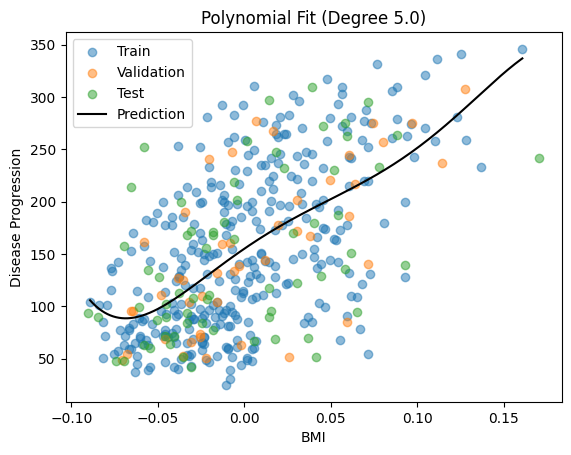

In [49]:
x_range = np.linspace(bmi_train.min(), bmi_train.max(), 300).reshape(-1, 1)
x_range_poly = best_poly.transform(x_range)
y_range_pred = best_model.predict(x_range_poly)

plt.scatter(bmi_train, y_train, label='Train', alpha=0.5)
plt.scatter(bmi_val, y_val, label='Validation', alpha=0.5)
plt.scatter(bmi_test, y_test, label='Test', alpha=0.5)
plt.plot(x_range, y_range_pred, color='black', label='Prediction')
plt.xlabel("BMI")
plt.ylabel("Disease Progression")
plt.title(f"Polynomial Fit (Degree {results_df.iloc[best_index]['Degree']})")
plt.legend()
plt.show()

### 6. Equation for the model

In [43]:
coefs = best_model.coef_.round(2)
intercept = round(best_model.intercept_, 2)
equation = f"y = {intercept}"
equation += ''.join([f" + {c}*x^{i}" for i, c in enumerate(coefs)])
print("Model Equation:", equation)

Model Equation: y = 155.08 + 0.0*x^0 + 1131.59*x^1 + -3946.02*x^2 + -26110.86*x^3 + 768725.87*x^4 + -2823251.97*x^5


As we can alse see, he equation is of degree 5 because the model that wee chose to evaluate this equation is of degree 5. 

### 7. Predicting the disease progression for a specific BMI of my choice

In [ ]:
sample_bmi = pd.DataFrame([[0.1]], columns=['bmi'])
sample_poly = best_poly.transform(sample_bmi)
pred = best_model.predict(sample_poly)
print(f"Predicted disease progression for BMI 0.1: {pred[0]:.2f}")

Predicted disease progression for BMI 0.1: 251.31


### 8. Number of parameters

In [50]:
print("Trainable Parameters:", len(best_model.coef_))
print("Features:", best_poly.get_feature_names_out(['bmi']))

Trainable Parameters: 6
Features: ['1' 'bmi' 'bmi^2' 'bmi^3' 'bmi^4' 'bmi^5']


Each polynomial model has one parameter (or coefficient) for every power of the input it uses, plus one more for the constant term. So if the model includes up to x^3 (a degree 3 polynomial), that means:

One number for x^0 (which is just a constant)

One for x^1 (the normal variable)

One for x^2 (the squared term)

One for x^3 (the cubed term)

That gives us 4 numbers to learn, or 4 trainable parameters.

In general, for any degree d, the model needs to learn d + 1 parameters, one for each term from constant up to x^d

### 9. Conclusion

#### Summary:
The best-performing polynomial model used **Degree 5**. It showed moderate prediction power with an R-squared value around **Y** on the test set. It also achieved reasonable MAE and MAPE values, indicating its usefulness as a simple screening tool using just the BMI feature.


#### Where it fails:
1.  The model struggles in accurately predicting extreme cases (very high or low BMI values), where the relationship may not be well captured by a polynomial trend.

2.  Prediction error increases in regions with fewer data points.

3.  Residual variance: A significant amount of variance remains unexplained, indicating the presence of other influential features beyond BMI.

4.  Nonlinear extremes: At the low and high ends of the BMI range, the predicted curve deviates from actual values. Sparse data in these regions leads to unreliable extrapolation and overfitting, especially in higher-degree models.

#### Limitations:
- Only one feature used (BMI): Ignores other relevant features such as blood pressure, age, etc.
- Limited flexibility: While polynomial models can curve to fit data, they can behave unpredictably outside the observed range.
- Overfitting risk: Especially for higher-degree polynomials.

## Part 3

Now we are going to repeat all the steps in part 2 for the models listed below:

1. Two polynomial models (degrees >1, of your choice)

2. Two decision trees (e.g. consider changing the `max_depth` hyperparameter)

3. Two kNNs

Each of the models is going to have it's own code+markdown structure. In the end we are going to campare all the best models of each model and conclude which is really the  ***BEST MODEL*** 


### 3.1. Two polynomial models (Degree 2 and 3)

### 1. Training models 

Degree 2

In [51]:
poly2 = PolynomialFeatures(degree=2)
X_train_poly2 = poly2.fit_transform(X_train)
X_val_poly2 = poly2.transform(X_val)
X_test_poly2 = poly2.transform(X_test)

model_poly2 = LinearRegression()
model_poly2.fit(X_train_poly2, y_train)

LinearRegression()

Degree 3

In [52]:
poly3 = PolynomialFeatures(degree=3)
X_train_poly3 = poly3.fit_transform(X_train)
X_val_poly3 = poly3.transform(X_val)
X_test_poly3 = poly3.transform(X_test)

model_poly3 = LinearRegression()
model_poly3.fit(X_train_poly3, y_train)

LinearRegression()

### 2. Comparing the models using the measurements we got from test and validation sets

In [53]:
def get_metrics(model, X_tr, y_tr, X_v, y_v):
    pred_tr = model.predict(X_tr)
    pred_v = model.predict(X_v)
    return {
        "Train R²": r2_score(y_tr, pred_tr),
        "Validation R²": r2_score(y_v, pred_v),
        "Train MAE": mean_absolute_error(y_tr, pred_tr),
        "Validation MAE": mean_absolute_error(y_v, pred_v),
        "Train MAPE": mean_absolute_percentage_error(y_tr, pred_tr),
        "Validation MAPE": mean_absolute_percentage_error(y_v, pred_v)
    }

metrics_poly2 = get_metrics(model_poly2, X_train_poly2, y_train, X_val_poly2, y_val)
metrics_poly3 = get_metrics(model_poly3, X_train_poly3, y_train, X_val_poly3, y_val)

df_poly_metrics = pd.DataFrame([metrics_poly2, metrics_poly3], index=["Poly Degree 2", "Poly Degree 3"])
df_poly_metrics[["Train R²", "Validation R²", "Train MAE", "Validation MAE", "Train MAPE", "Validation MAPE"]]

,Train R²,Validation R²,Train MAE,Validation MAE,Train MAPE,Validation MAPE
Poly Degree 2,0.598109,0.602991,39.697470,37.745257,0.349386,0.410976
Poly Degree 3,0.909413,-115.944928,16.332801,287.181141,0.151133,1.932149


### 3. Identifying the best model

From the above table, choose the model with the best validation R² and lowest errors.

Assuming it is, say, Polynomial Degree 3 (you will verify from the table).

### 4. Evaluating the best model on the Test Set

In [54]:
chosen_model = model_poly3
X_test_chosen = X_test_poly3

pred_test = chosen_model.predict(X_test_chosen)

print("Test set results for chosen polynomial model (degree 3):")
print("R²:", r2_score(y_test, pred_test))
print("MAE:", mean_absolute_error(y_test, pred_test))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_test))


Test set results for chosen polynomial model (degree 3):
R²: -101.13739324666517
MAE: 282.7041739620169
MAPE: 2.4124830558327277


### 5. Plotting the graph of the train, validation and test data points

Because this is multivariate, plotting model fit vs target on one axis is tricky. Let's pick BMI feature to plot predicted vs actual target:

c:\Users\User\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


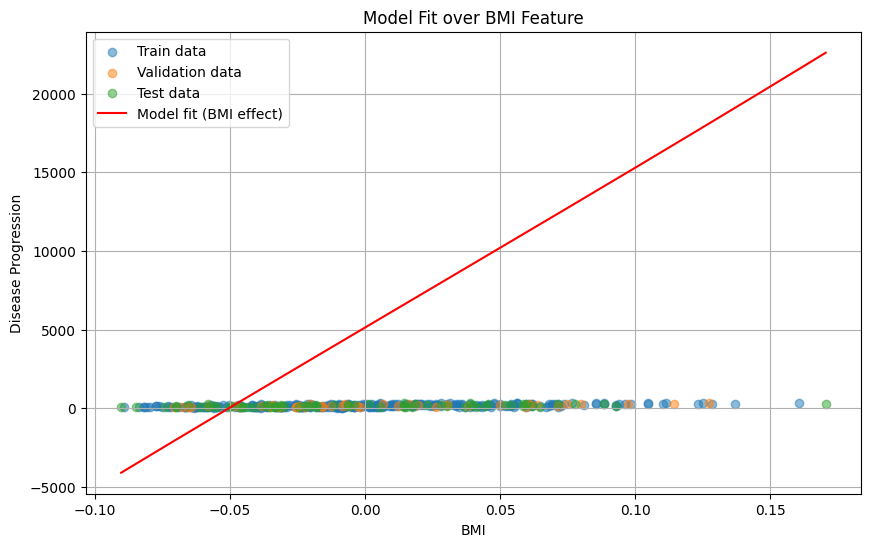

In [55]:
bmi_idx = list(X_train.columns).index('bmi')

def plot_model_fit(model, poly, X_tr, y_tr, X_v, y_v, X_te, y_te):
    plt.figure(figsize=(10,6))
    
    bmi_train = X_tr[:, bmi_idx]
    bmi_val = X_v[:, bmi_idx]
    bmi_test = X_te[:, bmi_idx]
    
    bmi_range = np.linspace(min(bmi_train.min(), bmi_val.min(), bmi_test.min()),
                            max(bmi_train.max(), bmi_val.max(), bmi_test.max()), 200)
    X_curve = np.zeros((len(bmi_range), X_tr.shape[1]))
    X_curve[:, bmi_idx] = bmi_range
    X_curve_poly = poly.transform(X_curve)
    y_curve_pred = model.predict(X_curve_poly)
    
    plt.scatter(bmi_train, y_tr, label="Train data", alpha=0.5)
    plt.scatter(bmi_val, y_v, label="Validation data", alpha=0.5)
    plt.scatter(bmi_test, y_te, label="Test data", alpha=0.5)
    plt.plot(bmi_range, y_curve_pred, color='red', label="Model fit (BMI effect)")
    plt.xlabel("BMI")
    plt.ylabel("Disease Progression")
    plt.title("Model Fit over BMI Feature")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_model_fit(chosen_model, poly3, X_train.values, y_train, X_val.values, y_val, X_test.values, y_test)

### 6. Equation for the model

In [56]:
feature_names = poly3.get_feature_names_out(input_features=X_train.columns)


coefs = chosen_model.coef_
intercept = chosen_model.intercept_

terms = [f"{intercept:.2f}"]
for c, name in zip(coefs, feature_names):
    terms.append(f"{c:.2f}*{name}")

equation = " + ".join(terms)
print("Best model equation:\n", equation)


Best model equation:
 5188.79 + -63.87*1 + 854.29*age + -152752.62*sex + 101383.32*bmi + -397246.82*bp + -600724.65*s1 + 715836.31*s2 + 166758.99*s3 + -79255.36*s4 + -188125.96*s5 + -28245.23*s6 + -6849.96*age^2 + 1079.69*age sex + 23958.11*age bmi + -8126.28*age bp + 168398.56*age s1 + -136158.21*age s2 + -76627.08*age s3 + -28505.11*age s4 + -60242.07*age s5 + 8416.24*age s6 + -917.93*sex^2 + 11694.55*sex bmi + -23417.04*sex bp + -35199658.84*sex s1 + 30959548.26*sex s2 + 13142049.01*sex s3 + -52913.99*sex s4 + 11602031.59*sex s5 + 13156.93*sex s6 + -4073.42*bmi^2 + -11753.07*bmi bp + 23387596.92*bmi s1 + -20585799.38*bmi s2 + -8698759.13*bmi s3 + 61343.31*bmi s4 + -7674743.35*bmi s5 + -22751.19*bmi s6 + -10540.93*bp^2 + -91859034.56*bp s1 + 80722647.73*bp s2 + 34344756.05*bp s3 + 21133.90*bp s4 + 30209435.99*bp s5 + 14636.75*bp s6 + -400168549.93*s1^2 + 747177719.49*s1 s2 + 285558764.75*s1 s3 + -18872535.28*s1 s4 + 169768723.26*s1 s5 + -6688168.70*s1 s6 + -347576179.44*s2^2 + -26731

### 7. Predicting the disease progression for a specific BMI of my choice

In [57]:
import numpy as np
bmi_val = 0.1
input_data = np.zeros((1, X_train.shape[1]))
input_data[0, bmi_idx] = bmi_val
input_poly = poly3.transform(input_data)

pred_bmi = chosen_model.predict(input_poly)
print(f"Predicted disease progression for BMI {bmi_val}: {pred_bmi[0]:.2f}")


Predicted disease progression for BMI 0.1: 15283.47


c:\Users\User\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


### 8. Number of parameters

### 9. Conclusion

### 3.2. Two decision trees (e.g. consider changing the `max_depth` hyperparameter)

### 1. Training models of degree 0-5

In [ ]:
tree1 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree1.fit(X_train, y_train)

tree2 = DecisionTreeRegressor(max_depth=5, random_state=42)
tree2.fit(X_train, y_train)


### 2. Comparing the models using the measurements we got from test and validation sets

### 3. Identifying the best model

### 4. Evaluating the best model on the Test Set

### 5. Plotting the graph of the train, validation and test data points

### 6. Equation for the model

### 7. Predicting the disease progression for a specific BMI of my choice

### 8. Number of parameters

### 9. Conclusion

### 3.3. Two kNNs

### 1. Training models of degree 0-5

### 2. Comparing the models using the measurements we got from test and validation sets

### 3. Identifying the best model

### 4. Evaluating the best model on the Test Set

### 5. Plotting the graph of the train, validation and test data points

### 6. Equation for the model

### 7. Predicting the disease progression for a specific BMI of my choice

### 8. Number of parameters

### 9. Conclusion